In [0]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt


def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield(np.array([(x, random.uniform(0, 1)) for _ in range(batch_size)]))

def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 2)))

def distribution3(batch_size=512):
    # 1D gaussian distribution
    while True:
        yield(np.random.normal(0, 1, (batch_size, 1)))

e = lambda x: np.exp(x)
tanh = lambda x: (e(x) - e(-x)) / (e(x)+e(-x))
def distribution4(batch_size=1):
    # arbitrary sampler
    f = lambda x: tanh(x*2+1) + x*0.75
    while True:
        yield(f(np.random.normal(0, 1, (batch_size, 1))))


In [0]:
#Objective function for the Jensen-Shannon Divergence
def JSD(dist1, dist2, Discriminator):
    x_1 = torch.from_numpy(next(dist1)).float()
    x_2 = torch.from_numpy(next(dist2)).float()
    y_1 = Discriminator(x_1)
    y_2 = Discriminator(x_2)
    y_1 = torch.sigmoid(y_1)
    y_2 = torch.sigmoid(y_2)
    jsd = np.log(2) + (0.5*torch.mean(torch.log(y_1)) + 0.5*torch.mean(torch.log(1 - y_2))).data.cpu().numpy()
    return jsd

In [0]:
#Objective function for the Wasserstein Distance
def WD(dist1, dist2, Discriminator):
    x_1 = torch.from_numpy(next(dist1)).float()
    x_2 = torch.from_numpy(next(dist2)).float()
    y_1 = Discriminator(x_1)
    y_2 = Discriminator(x_2)
    wd = (torch.mean(y_1) - torch.mean(y_2)).data.cpu().numpy()
    return wd

In [0]:
#Three Layer MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [0]:
#Train method
def train_JSD(dist1, dist2, Discriminator):
    sgd = SGD(Discriminator.parameters(), lr=0.001)
    for i in range(50000):
        sgd.zero_grad()
        x_1 = torch.from_numpy(next(dist1)).float()
        x_2 = torch.from_numpy(next(dist2)).float()
        y_1 = Discriminator(x_1)
        y_2 = Discriminator(x_2)  
        y_1 = torch.sigmoid(y_1)
        y_2 = torch.sigmoid(y_2)
        loss = - torch.mean(torch.log(y_1)) - torch.mean(torch.log(1 - y_2))
        loss.backward()
        sgd.step()
    return Discriminator

In [0]:
#plot JSD
data = ([],[])
dist1 = distribution1(0)
for x in np.arange(-1.0, 1.01, 0.1):
    x = np.around(x, decimals=1)
    #print("x = " + str(x))
    dist2 = distribution1(x, batch_size=512)
    D = MLP(2)
    Discriminator = train_JSD(dist1, dist2, D)
    y = JSD(dist1, dist2, Discriminator)
    data[0].append(x)
    data[1].append(y)

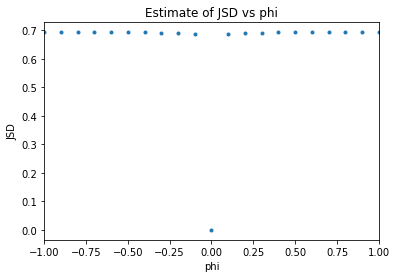

In [0]:
plt.plot(data[0], data[1], '.')
plt.xlim(-1, 1)
plt.xlabel('phi')
plt.ylabel('JSD')
plt.title('Estimate of JSD vs phi')
plt.show()

In [0]:
#train WD
def train_WD(dist1, dist2, Discriminator):
    sgd = SGD(Discriminator.parameters(), lr=0.001)
    dist_u = distribution2(batch_size=512)
    lambda_ = 10
    for i in range(40000):
        sgd.zero_grad()
        x_1 = torch.from_numpy(next(dist1)).float()
        x_2 = torch.from_numpy(next(dist2)).float()
        y_1 = Discriminator(x_1)
        y_2 = Discriminator(x_2)
        num = torch.from_numpy(next(dist_u)).float()
        x_z = num*x_1 + (1 - num)*x_2
        x_z.requires_grad = True
        y_z = Discriminator(x_z)
        grad_z = torch.autograd.grad(y_z, x_z, grad_outputs=torch.ones(y_z.size()), retain_graph=True, create_graph=True, only_inputs=True)[0]
        loss = -(torch.mean(y_1) - torch.mean(y_2) - lambda_*torch.mean((torch.norm(grad_z, p=2, dim=1)-1)**2))        
        loss.backward()
        sgd.step()
    return Discriminator

x = -1.0
x = -0.9
x = -0.8
x = -0.7
x = -0.6
x = -0.5
x = -0.4
x = -0.3
x = -0.2
x = -0.1
x = -0.0
x = 0.1
x = 0.2
x = 0.3
x = 0.4
x = 0.5
x = 0.6
x = 0.7
x = 0.8
x = 0.9
x = 1.0


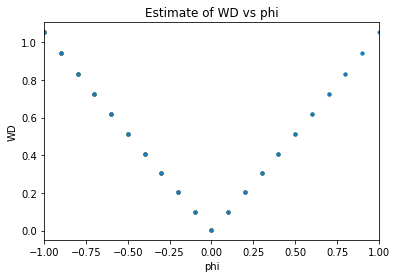

In [0]:
#plot WD
data = ([],[])
dist1 = distribution1(0)
for x in np.arange(-1.0, 1.01, 0.1):
    x = np.around(x, decimals=1)
    #print("x = " + str(x))
    dist2 = distribution1(x)
    D = MLP(2)
    Discriminator = train_WD(dist1, dist2, D)
    y = WD(dist1, dist2, Discriminator)
    data[0].append(x)
    data[1].append(y)
    plt.plot(data[0], data[1], '.')
plt.xlim(-1, 1)
plt.xlabel('phi')
plt.ylabel('WD')
plt.title('Estimate of WD vs phi')
plt.show()

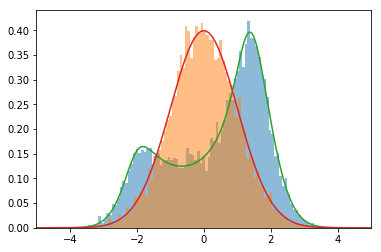

In [0]:
# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))

############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

In [0]:
#######--- INSERT YOUR CODE BELOW ---#######
dist4 = distribution4(batch_size=256)
dist3 = distribution3(batch_size=256)
D = MLP(1)
Discriminator = train_JSD(dist4, dist3, D)
input = torch.from_numpy(xx).float()
input = torch.unsqueeze(input, 1)
Dx = torch.squeeze(torch.sigmoid(Discriminator(input)), 1).data.cpu().numpy()
#f1 = f0 D*(x) / (1 - D*(x))
#where D*(x) = argmax_D E(log(Dx)) + E(log(1-Dx))
f_1 = N(xx)*Dx/(1-Dx)

Text(0.5, 1.0, 'Estimated vs True')

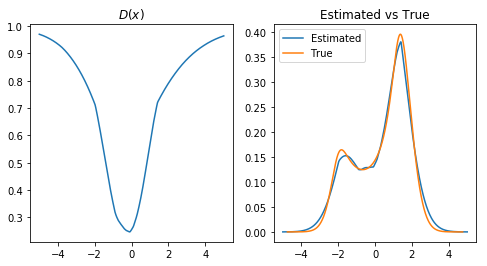

In [0]:
############### plotting things
############### (1) plot the output of your trained discriminator 
############### (2) plot the estimated density contrasted with the true density

r = Dx # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = f_1 # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')